<h1 style='font-size:20px;text-align: center'>
A machine learning algorithm based on Gaussian processes 
<br> for MODIS multilayer cloud and thermodynamic phase 
<br> classification using CALIOP and CloudSat
</h1>

<p style='text-align: center'>
Author: Benjamin Marchant 
<br>(marchant.benjamin01@gmail.com)
<br>(benjamin.marchant@nasa.gov)
<br> v1.0.0
</p>

This Jupyter notebook presents a machine learning algorithm based on Gaussian processes to detect cloud thermodynamic phase and multilayer clouds for the MODIS (Moderate Resolution Imaging Spectroradiometer) instrument. The algorithm is trained using a co-located dataset between MODIS CALIOP and CloudSat.

Note 1: dataset used to train the algorithm can be downloaded on Github or 

Note 2: More information about the author can be found on the following <a href="https://moonbooks.org/Notebooks/6364d3f0f495b6ab9dcf8d3b5c6e0b01/">open notebook</a>

![Aqua](https://eospso.nasa.gov/sites/default/files/sat/Aqua_b.jpg)

Table of Content:

* [Read MODIS CALIOP CLoudSat Co-located Dataset](#dataset)
* [Create cloud phase & multilayer cloud labels](#labels) 
* [Data Preparation (scaling and standardization)](#data_preparation)
* [Create a learning function](#learning_function)
* [Create an evaluation function](#evaluation_function)
* [Train a model that detect monolayer liquid cloud](#monolayer_liquid)
* [Train a model that detect monolayer ice cloud](#monolayer_ice)
* [Train a model that detect monolayer mixed cloud](#monolayer_mixed)
* [Train a model that detect multilayer (ice / liquid) cloud](#multilayer_ice_liquid)
* [Train a model that detect multilayer (ice / mixed) cloud](#multilayer_ice_mixed)
* [Train a model that detect multilayer (ice / ice) cloud](#multilayer_ice_ice)
* [Train a model that detect multilayer (liquid / liquid) cloud](#multilayer_liquid_liquid)

In [46]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

from pyhdf.SD import SD, SDC 
from matplotlib.pyplot import figure
from random import shuffle 
from scipy.spatial.distance import pdist, cdist

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import numpy.ma as ma
import pprint
import warnings

warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Read MODIS CALIOP CLoudSat Co-located Dataset <a class="anchor" id="dataset"></a>

To train the algorithm, a co-located MODIS CALIOP and CloudSat Dataset has been created using random sampling of pixels selected during the month of January 2008 (5.000 pixels selected randomly each day -> dataset size 31*5000=155000):

In [3]:
df = pd.read_csv('../data/2008_01_colocated_modis_caliop_cloudsat_random_sample_dataset.csv',index_col=False)

print('dataframe shape',df.shape)

dataframe shape (155000, 113)


The file includes the following information:

In [4]:
column_names_list = df.columns

for name in column_names_list:
    print(name)

modis_multilayer_cloud
modis_multilayer_cloud_qa1
modis_multilayer_cloud_qa2
modis_multilayer_cloud_qa3
modis_multilayer_cloud_qa4
modis_multilayer_cloud_qa5
modis_cloud_phase
latitude
longitude
modis_cloud_top_height_1km
modis_cloud_effective_radius
modis_cloud_effective_radius_16
modis_cloud_effective_radius_37
modis_cloud_optical_thickness
surface_flag
nb_tot_cloud_layers
caliop_1km_nb_cloud_layers
caliop_5km_nb_cloud_layers
cldclass_lidar_nb_cloud_layers
modis_band_1
modis_band_2
modis_band_3
modis_band_4
modis_band_5
modis_band_6
modis_band_7
modis_band_8
modis_band_9
modis_band_10
modis_band_11
modis_band_12
modis_band_13l
modis_band_13h
modis_band_14l
modis_band_14h
modis_band_15
modis_band_16
modis_band_17
modis_band_18
modis_band_19
modis_band_26
modis_band_20
modis_band_21
modis_band_22
modis_band_23
modis_band_24
modis_band_25
modis_band_27
modis_band_28
modis_band_29
modis_band_30
modis_band_31
modis_band_32
modis_band_33
modis_band_34
modis_band_35
modis_band_36
modis_band

In [5]:
df.head(10)

,modis_multilayer_cloud,modis_multilayer_cloud_qa1,modis_multilayer_cloud_qa2,modis_multilayer_cloud_qa3,modis_multilayer_cloud_qa4,modis_multilayer_cloud_qa5,modis_cloud_phase,latitude,longitude,modis_cloud_top_height_1km,...,cloud_layer_top_09,cloud_layer_base_09,cloud_layer_optical_depth_09,cloud_layer_phase_09,cloud_layer_source_09,cloud_layer_top_10,cloud_layer_base_10,cloud_layer_optical_depth_10,cloud_layer_phase_10,cloud_layer_source_10
0,5.0,1.0,0.0,0.0,0.0,1.0,2.0,-49.767658,-144.492096,2700.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,7.892334,87.800476,4750.0,...,2.049999,1.449999,0.0,3.0,3.0,0.0,0.0,-9999.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-52.644794,29.831434,500.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,2.0,28.681301,-40.599194,50.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-67.958023,-82.737038,1250.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-60.335007,-138.910355,850.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
6,8.0,0.0,1.0,1.0,0.0,1.0,3.0,-63.907398,36.836395,7450.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-23.554411,-4.174837,0.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-16.378271,-30.564116,2800.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,4.0,-6.938173,115.692223,7150.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0


Remove rows with no data or clear pixels:

In [6]:
df = df[df.modis_multilayer_cloud != 0]

print('dataframe shape',df.shape)

dataframe shape (111558, 113)


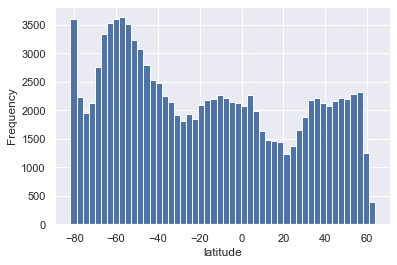

In [7]:
df['latitude'].plot(kind='hist',bins=50)

plt.xlabel('latitude')

plt.show()

Remove pixels with latitude > 70:

In [8]:
df = df.loc[ abs( df['latitude'] ) < 70]

print('dataframe shape',df.shape)

dataframe shape (101483, 113)


Gaussian processes are a "Lazy Learning" method (meaning that the training dataset will be used to make each new predictions). So it becomes slower with incrising the training dataset size. To avoid that, let's just take a smaller sample size: 

In [9]:
df = df.sample(n=10000, random_state = 42)
#df = df.sample(n=10000)
#df = df.head(n=10000)

In [10]:
df.shape

(10000, 113)

### Create cloud phase & multilayer cloud labels <a class="anchor" id="labels"></a>

Using the cldclass-lidar product (corresponding to cloud_layer_source = 3) in the dataset, let's define monolayer and multilayer clouds labels that will be used to train the machine learning algorithm:

In [11]:
df['label 1'] = 'unlabeled'
df['label 2'] = 'unlabeled'

#print(df.head())

for index, row in df.iterrows():
    nb_cloud_layer = 0
    cloud_phase_per_layer_list = []
    for layer_idx in range(10):
        if int( row['cloud_layer_source_{:02d}'.format(layer_idx+1)] ) == 3: # cldclass-lidar product
            cloud_phase_per_layer_list.append( int( row['cloud_layer_phase_{:02d}'.format(layer_idx+1)] ) )
            nb_cloud_layer = nb_cloud_layer + 1
    if nb_cloud_layer == 1: # monolayer cloud   
        df.loc[index,'label 1'] = 'monolayer (n=1)'
        if cloud_phase_per_layer_list[0] == 1: df.loc[index,'label 2'] = 'ice'
        if cloud_phase_per_layer_list[0] == 2: df.loc[index,'label 2'] = 'mixed'    
        if cloud_phase_per_layer_list[0] == 3: df.loc[index,'label 2'] = 'liquid'
    if nb_cloud_layer == 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n=2)'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'ice / ice'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'ice / liquid'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 2: 
            df.loc[index,'label 2'] = 'ice / mixed'
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'liquid / liquid'
        if cloud_phase_per_layer_list[0] == 2 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'mixed / liquid'    
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'liquid / ice'
    if nb_cloud_layer > 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n>2)'

In [12]:
df['label 1'].value_counts()

monolayer (n=1)     5842
multilayer (n=2)    2661
multilayer (n>2)    1079
unlabeled            418
Name: label 1, dtype: int64

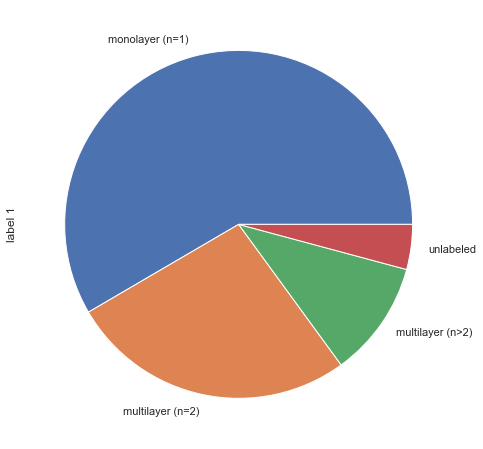

In [13]:
df['label 1'].value_counts().plot(kind='pie', figsize=(8, 8))

plt.show()

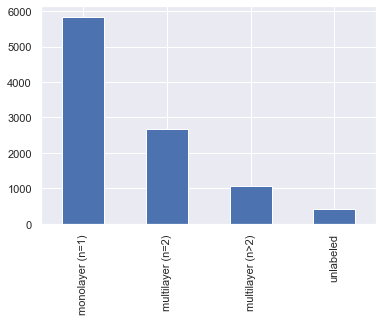

In [14]:
df['label 1'].value_counts().plot(kind='bar')

plt.show()

In [15]:
df['label 2'].value_counts()

liquid             2908
ice                1624
unlabeled          1560
mixed              1310
ice / liquid       1237
ice / mixed         479
ice / ice           452
liquid / liquid     271
mixed / liquid      151
liquid / ice          8
Name: label 2, dtype: int64

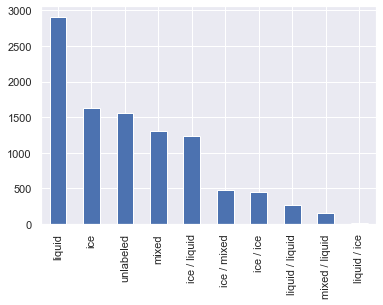

In [16]:
df['label 2'].value_counts().plot(kind='bar')

plt.show()

In [17]:
df.drop( df[(df['label 1'] == 'unlabeled' ) | (df['label 2'] == 'unlabeled')].index, inplace=True )

print(df.shape)

(8440, 115)


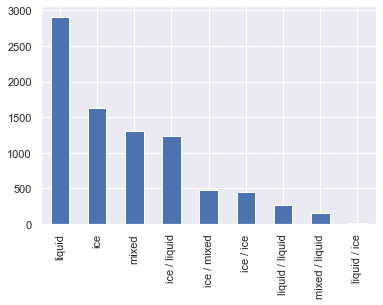

In [18]:
df['label 2'].value_counts().plot(kind='bar')

plt.savefig('output.png', bbox_inches='tight')
plt.show()

### Data Preparation (scaling and standardization) <a class="anchor" id="data_preparation"></a>

Split the dataset between a training and testing dataset:

In [19]:
df_train, df_test = train_test_split(df, test_size = .3, random_state = 42)

print(df_train.shape)

(5908, 115)


Test data scaling with 0 mean and std = 1:

In [20]:
df_sub_cutoff = df_train.sample(n=300, random_state=42)

features = [col for col in df if col.startswith('modis_band')] 

X_train = np.array(df_sub_cutoff[features])

scaler = preprocessing.StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)

print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

print(X_scaled.shape)

[-1.36187358e-16  8.88178420e-17  5.32907052e-17 -1.24344979e-16
  5.92118946e-17  3.55271368e-17 -1.18423789e-17 -7.84557604e-17
  2.96059473e-17 -5.32907052e-17 -1.77635684e-17  1.77635684e-17
 -1.77635684e-17  0.00000000e+00 -1.48029737e-17  9.84989867e-14
 -5.92118946e-18  5.92118946e-18 -5.92118946e-17  8.28966525e-17
 -5.32907052e-17  2.07241631e-17 -8.28966525e-17  8.88178420e-18
  7.99360578e-17 -1.12502600e-16 -1.53950926e-16 -8.58572472e-17
 -8.88178420e-17  1.89478063e-16  8.88178420e-17 -4.44089210e-18
 -1.33226763e-16  1.64313008e-16 -2.22044605e-17  1.43588845e-16
  2.02800739e-16 -8.88178420e-18  1.71714494e-16  7.69754630e-17
 -7.69754630e-17 -1.18423789e-17 -2.36847579e-17  0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
(300, 44)


In [21]:
X_test_scaled = scaler.transform(df_test[features]) 

print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))

print(X_test_scaled.shape)

[-5.81856825e-02 -6.78804943e-02 -5.17735784e-02 -6.15159463e-02
 -5.89387757e-02  4.65341793e-02 -1.20713567e-02 -1.72980244e-04
  1.00707993e-01  1.62606939e-02  1.73326513e-02  7.67627094e-02
  4.67352770e-02  4.06531465e-02  6.28327948e-02  1.85762809e+02
  9.23131580e-02  3.80820084e-02 -2.02189641e-02 -4.63880326e-02
 -5.10592757e-02 -3.93622681e-02  3.18663483e-02  4.64098035e-02
  3.30134167e-02  3.29881011e-02  4.76278412e-02  3.77397670e-02
  6.85382961e-02  6.78638654e-02  4.11945284e-02  4.23541253e-02
  4.76757616e-02  4.99791226e-02  6.16795863e-02  6.63279767e-02
  7.31955291e-02 -1.50289942e-03 -4.33422773e-02 -2.92689934e-02
 -5.08739332e-02  4.43642983e-02  8.69657633e-03  0.00000000e+00]
[9.73869571e-01 9.88688595e-01 9.70094991e-01 9.69260520e-01
 9.83009531e-01 1.00071800e+00 9.61138201e-01 9.91376546e-01
 1.03143173e+00 1.00227845e+00 9.97754229e-01 1.08376076e+00
 1.06792765e+00 1.19040860e+00 1.09619494e+00 3.56676503e+03
 1.16064187e+00 1.06145797e+00 1.0083966

Create a function that prepare the data:

In [22]:
def data_preparation(df_train, df_test, max_train_sample_size, label_name):

    df_train_processed = df_train.copy()
    df_test_processed = df_test.copy()
    
    #----- data class balanced -----#    
    
    print(df_train_processed['label 2'].value_counts())
    
    df_train_processed['label 2'][ df_train_processed['label 2'] != label_name ] = '(not) ' + label_name
 
    df_train_processed['label 2'].value_counts().plot(kind='bar')

    plt.show()  

    #----- data class balanced -----#     
    
    # Separate majority and minority classes
    df_majority = df_train_processed[ df_train_processed['label 2'] != label_name ]
    df_minority = df_train_processed[ df_train_processed['label 2'] == label_name ]
    
    df_minority_len = len(df_minority)
    
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority_len,     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_train_processed = pd.concat([df_majority_downsampled, df_minority])
    
    #print(df_train_processed)
    
    print(df_train_processed['label 2'].value_counts())

    df_train_processed['label 2'].value_counts().plot(kind='bar')

    plt.show() 
    
    #----- data train scaling -----#
    
    features = [col for col in df if col.startswith('modis_band')] 
    
    #print(df_train_processed[features])
    
    X_train = df_train_processed[features]

    scaler = preprocessing.StandardScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    
    #print(X_train_scaled.mean(axis=0))
    #print(X_train_scaled.std(axis=0))

    #print(X_train_scaled.shape)    

    df_train_processed[features] = X_train_scaled
    
    #print(df_train_processed[features])
    
    #----- data test scaling -----#    
    
    X_test_scaled = scaler.transform(df_test_processed[features])
    
    df_test_processed[features] = X_test_scaled
    
    df_test_processed['label 2'][ df_test_processed['label 2'] != label_name ] = '(not) ' + label_name
    
    #----- data sub sampling -----#
    
    if df_minority_len * 2.0 > max_train_sample_size:

        df_majority = df_train_processed[ df_train_processed['label 2'] != label_name ]
        df_minority = df_train_processed[ df_train_processed['label 2'] == label_name ]    

        df_majority = df_majority.sample(n=int(max_train_sample_size/2.0), random_state=42)
        df_minority = df_minority.sample(n=int(max_train_sample_size/2.0), random_state=42)

        df_train_processed = pd.concat([df_majority, df_minority])

        df_train_processed['label 2'].value_counts().plot(kind='bar')

        plt.show()     

    return scaler, df_train_processed, df_test_processed

### Create a learning function<a class="anchor" id="learning_function"></a>

In [23]:
def train_gp_model(label_name, features_train, df_train_processed):

    df_train_column_names_list = list(df.columns)

    features_train_idx = [df_train_column_names_list.index(i) for i in features_train] 
    
    kernel = C(1.0, (0.1, 10.0)) * RBF([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2], (1e-2, 1e2))

    gp = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=20)

    gp.fit(df_train_processed.iloc[:,features_train_idx], df_train_processed['label 2'])
    
    return gp

### Create an evaluation function <a class="anchor" id="evaluation_function"></a>


In [24]:
def evaluate_gp_model(label_name, features_train, gp, df_test_processed):
    
    df_train_column_names_list = list(df.columns)

    features_train_idx = [df_train_column_names_list.index(i) for i in features_train]  
    
    y_true = df_test_processed['label 2']
    y_pred = gp.predict_proba(df_test_processed.iloc[:,features_train_idx])
    
    df_test_processed['label 2'].value_counts().plot(kind='bar')

    plt.show() 

    y_pred_list = []
    y_liq_liq_list = []
    y_liq_notliq_list = []
    y_notliq_liq_list = []
    y_notliq_notliq_list = []
    for i in range(y_pred.shape[0]):
        #print(y_pred[i,0],y_pred[i,1],y_true.iloc[i])
        if y_pred[i,0] >= 0.5:
            y_pred_list.append('(not) ' + label_name)
        else:
            y_pred_list.append(label_name)
        if y_true.iloc[i] == label_name:
            y_liq_liq_list.append(y_pred[i,1])
            y_liq_notliq_list.append(y_pred[i,0])  
        else:
            y_notliq_liq_list.append(y_pred[i,1])
            y_notliq_notliq_list.append(y_pred[i,0])                       
    
    print('accuracy_score:',accuracy_score(y_true, y_pred_list))  
    
    cm_data = confusion_matrix(y_true, y_pred_list) 

    #print(cm_data)
    
    label_list = ['(not) ' + label_name, label_name]
    label_list.sort()

    #df_cm = pd.DataFrame(100.0*cm_data/np.sum(cm_data), index = label_list, columns = label_list)

    #sns.heatmap(df_cm, annot=True)

    #plt.show()
    #plt.close()    
    
    plt.hist(y_liq_liq_list, alpha = 0.5, label=label_name)
    
    plt.hist(y_liq_notliq_list, alpha = 0.5, label='(not) ' + label_name)
    
    plt.title(label_name + ' -- True Label')
    
    plt.xlabel('Predicted Probability')
    plt.legend()
    
    plt.show()   
    
    plt.hist(y_notliq_liq_list, alpha = 0.5, label=label_name)
    
    plt.hist(y_notliq_notliq_list, alpha = 0.5, label='(not) ' + label_name)
    
    plt.title('(not) ' + label_name + ' -- True Label')
    
    plt.xlabel('Predicted Probability')
    
    plt.legend()
    
    plt.show()   
        
    fpr, tpr, _ = roc_curve(y_true, y_pred[:,1], pos_label=label_name)
    
    roc_auc = auc(fpr, tpr)
    plt.title('roc_auc = %0.2f' % roc_auc)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    
    plt.show()

    #print('log_loss', log_loss(y_true, y_pred))

    return None

### Train a model that detect monolayer liquid cloud <a class="anchor" id="monolayer_liquid"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


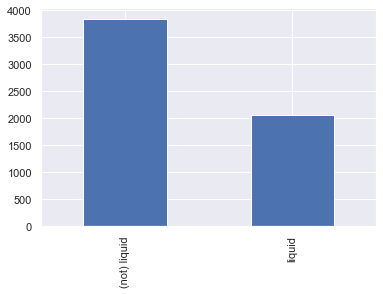

(not) liquid    2064
liquid          2064
Name: label 2, dtype: int64


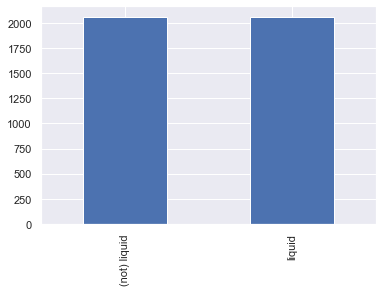

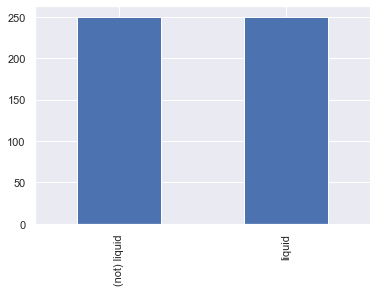

CPU times: user 401 ms, sys: 30.5 ms, total: 432 ms
Wall time: 433 ms


In [25]:
%%time

scaler_liquid, df_train_liquid_processed, df_test_liquid_processed = data_preparation(
                                            df_train, 
                                            df_test, 
                                            max_train_sample_size = 500, 
                                            label_name = 'liquid')

In [26]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_liquid = train_gp_model('liquid', features_train, df_train_liquid_processed)

CPU times: user 1min 51s, sys: 8.93 s, total: 2min
Wall time: 1min 4s


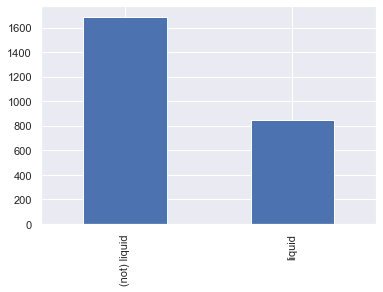

accuracy_score: 0.782780410742496


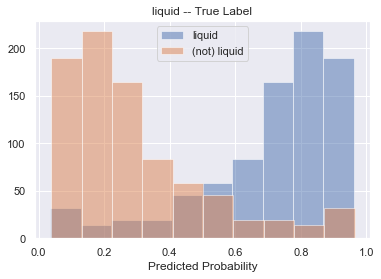

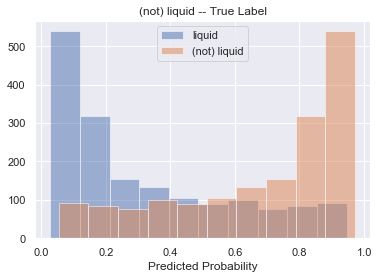

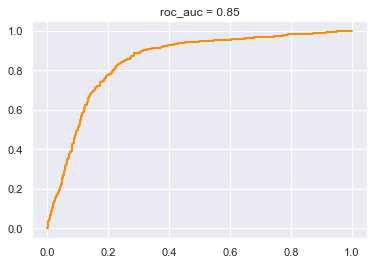

CPU times: user 1.13 s, sys: 27.9 ms, total: 1.16 s
Wall time: 965 ms


In [27]:
%%time

evaluate_gp_model('liquid', features_train, gp_liquid, df_test_liquid_processed)

### Train a model that detect monolayer ice cloud <a class="anchor" id="monolayer_ice"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


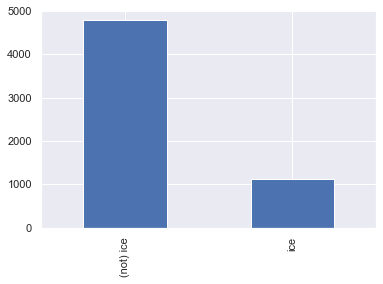

(not) ice    1124
ice          1124
Name: label 2, dtype: int64


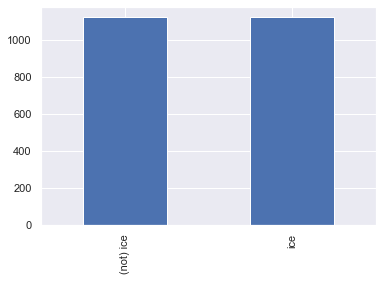

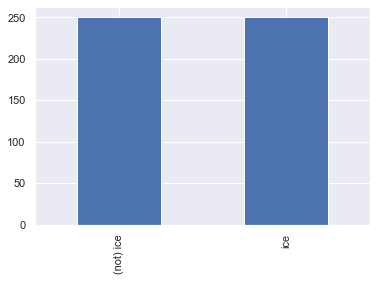

In [28]:
scaler_ice, df_train_ice_processed, df_test_ice_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'ice')

In [29]:
gp_ice = train_gp_model('ice', features_train, df_train_ice_processed)

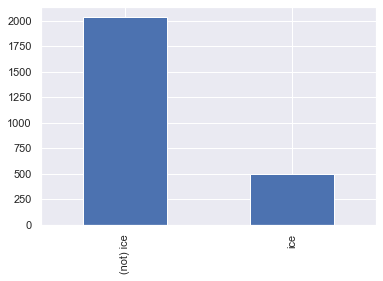

accuracy_score: 0.7863349131121643


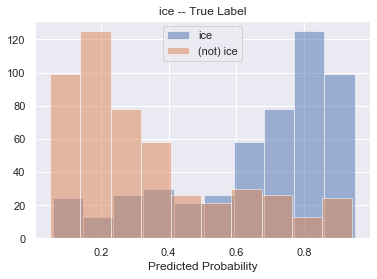

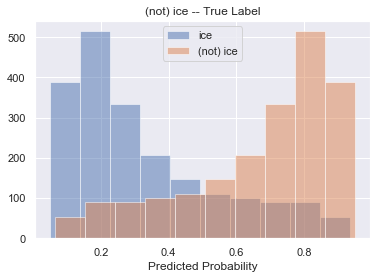

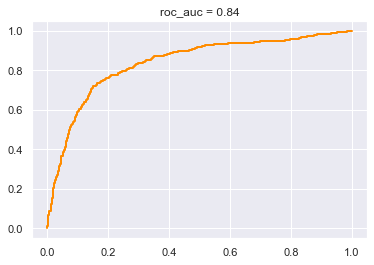

In [30]:
evaluate_gp_model('ice', features_train, gp_ice, df_test_ice_processed)

### Train a model that detect monolayer mixed cloud <a class="anchor" id="monolayer_mixed"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


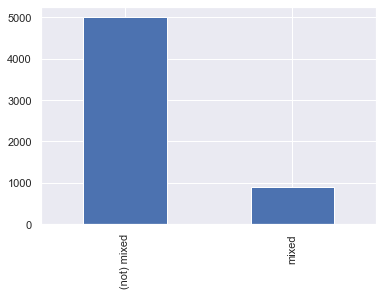

mixed          900
(not) mixed    900
Name: label 2, dtype: int64


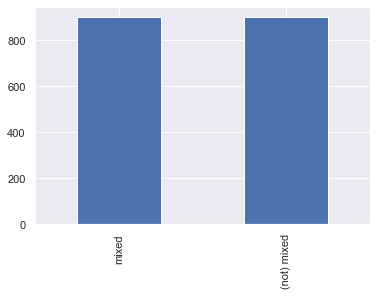

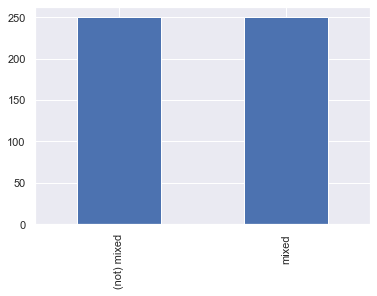

In [31]:
scaler_mixed, df_train_mixed_processed, df_test_mixed_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'mixed')

In [32]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_mixed = train_gp_model('mixed', features_train, df_train_mixed_processed)

CPU times: user 2min 28s, sys: 11.3 s, total: 2min 39s
Wall time: 1min 23s


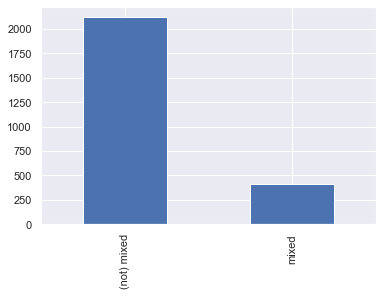

accuracy_score: 0.7338072669826224


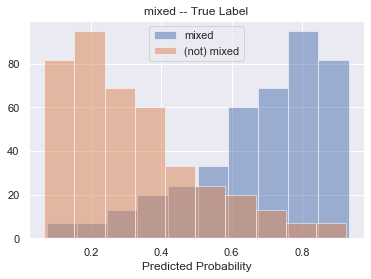

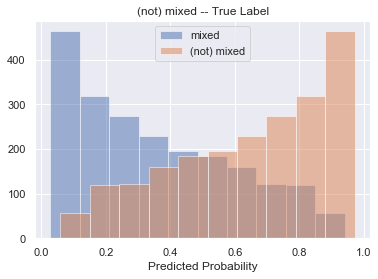

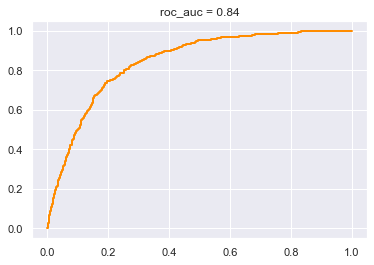

In [33]:
evaluate_gp_model('mixed', features_train, gp_mixed, df_test_mixed_processed)

### Train a model that detect multilayer (ice / liquid) cloud <a class="anchor" id="multilayer_ice_liquid"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


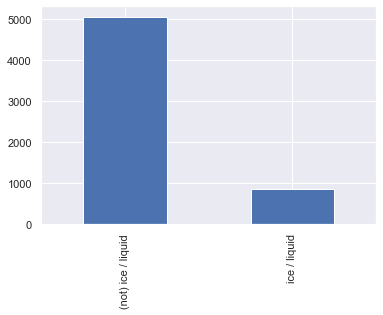

ice / liquid          855
(not) ice / liquid    855
Name: label 2, dtype: int64


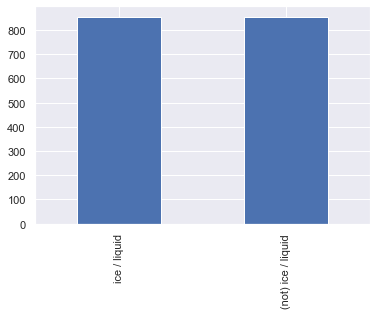

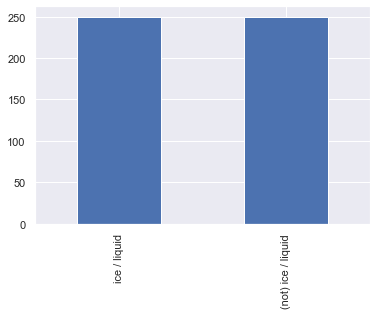

In [34]:
scaler_ice_over_liquid, df_train_ice_over_liquid_processed, df_test_ice_over_liquid_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'ice / liquid')

In [35]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_ice_over_liquid = train_gp_model('ice / liquid', features_train, df_train_ice_over_liquid_processed)

CPU times: user 2min 20s, sys: 10.8 s, total: 2min 31s
Wall time: 1min 20s


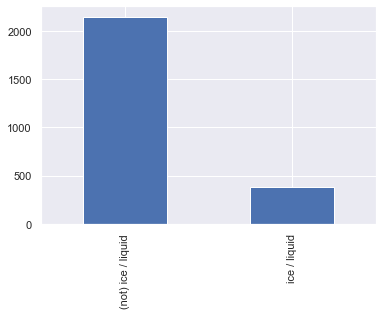

accuracy_score: 0.6184834123222749


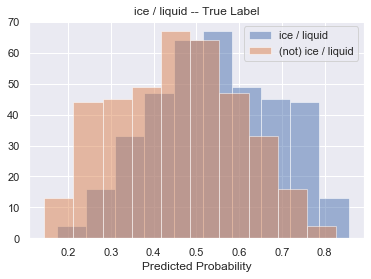

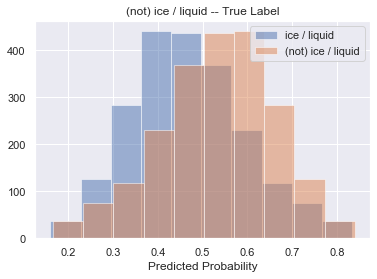

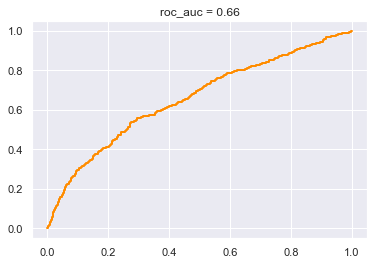

In [36]:
evaluate_gp_model('ice / liquid', features_train, gp_ice_over_liquid, df_test_ice_over_liquid_processed)

### Train a model that detect multilayer (ice / mixed) cloud <a class="anchor" id="multilayer_ice_mixed"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


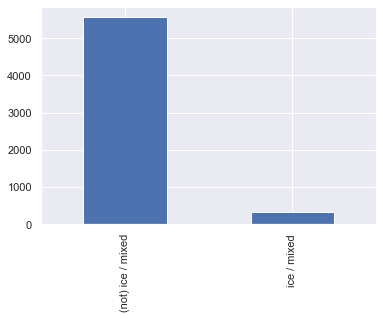

ice / mixed          333
(not) ice / mixed    333
Name: label 2, dtype: int64


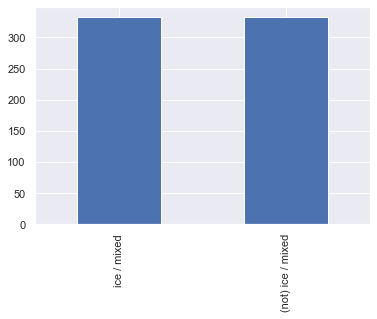

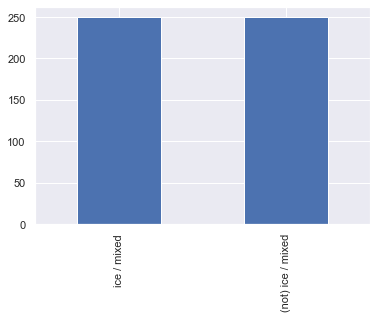

In [37]:
scaler_ice_over_mixed, df_train_ice_over_mixed_processed, df_test_ice_over_mixed_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'ice / mixed')

In [38]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_ice_over_mixed = train_gp_model('ice / mixed', features_train, df_train_ice_over_mixed_processed)

CPU times: user 2min 31s, sys: 12.8 s, total: 2min 44s
Wall time: 1min 28s


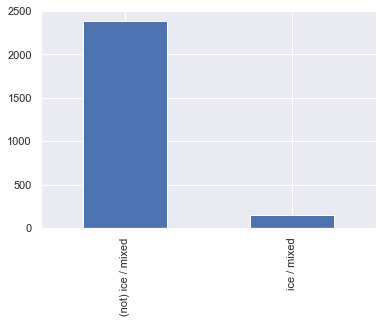

accuracy_score: 0.6358609794628752


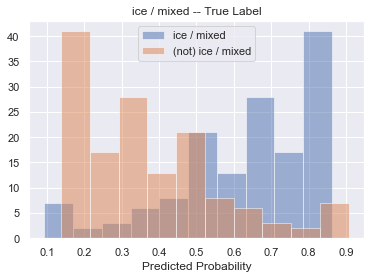

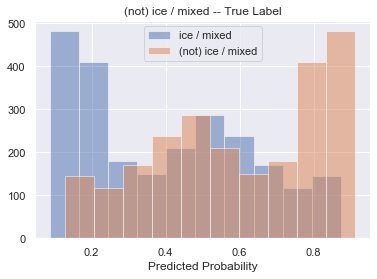

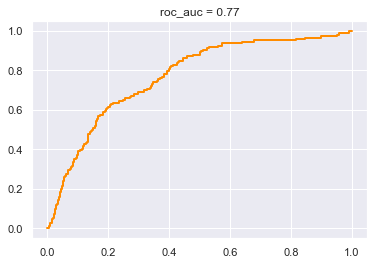

In [39]:
evaluate_gp_model('ice / mixed', features_train, gp_ice_over_mixed, df_test_ice_over_mixed_processed)

### Train a model that detect multilayer (ice / ice) cloud <a class="anchor" id="multilayer_ice_ice"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


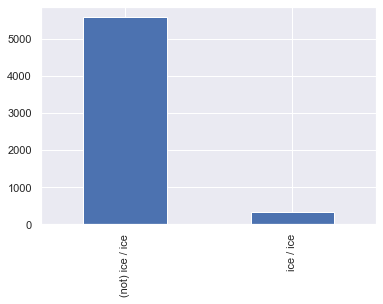

(not) ice / ice    331
ice / ice          331
Name: label 2, dtype: int64


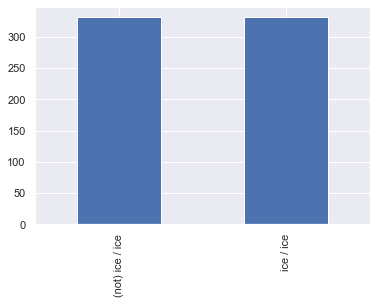

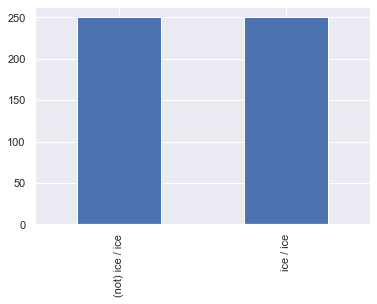

In [40]:
scaler_ice_over_ice, df_train_ice_over_ice_processed, df_test_ice_over_ice_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'ice / ice')

In [41]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_ice_over_ice = train_gp_model('ice / ice', features_train, df_train_ice_over_ice_processed)

CPU times: user 2min 11s, sys: 10.8 s, total: 2min 22s
Wall time: 1min 15s


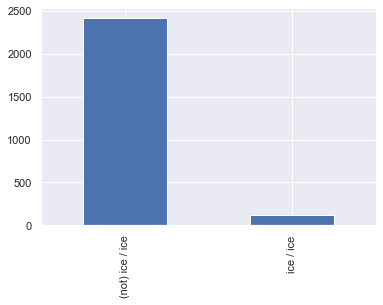

accuracy_score: 0.6453396524486572


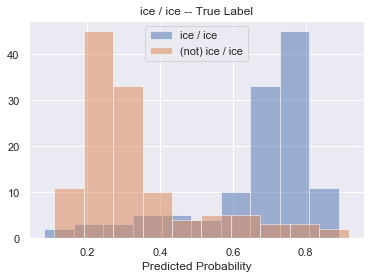

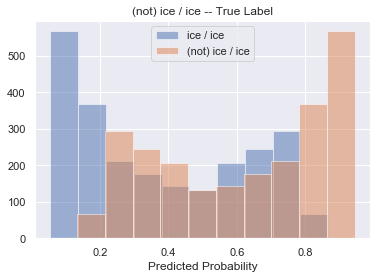

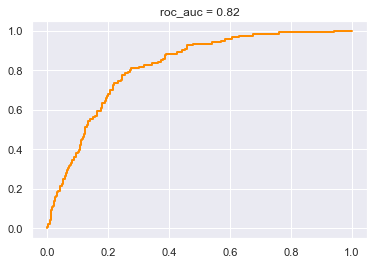

In [42]:
evaluate_gp_model('ice / ice', features_train, gp_ice_over_ice, df_test_ice_over_ice_processed)

### Train a model that detect multilayer (liquid / liquid) cloud <a class="anchor" id="multilayer_liquid_liquid"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


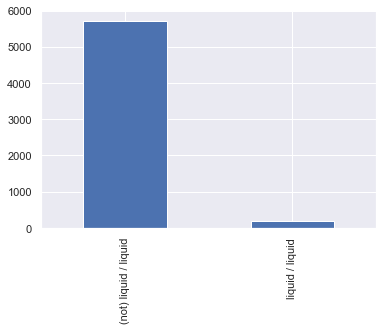

(not) liquid / liquid    193
liquid / liquid          193
Name: label 2, dtype: int64


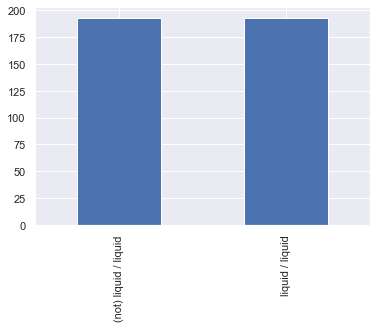

In [43]:
scaler_liquid_over_liquid, df_train_liq_over_liq_processed, df_test_liq_over_liq_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'liquid / liquid')

In [44]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_liq_over_liq = train_gp_model('liquid / liquid', features_train, df_train_liq_over_liq_processed)

CPU times: user 1min 9s, sys: 6.25 s, total: 1min 15s
Wall time: 39.7 s


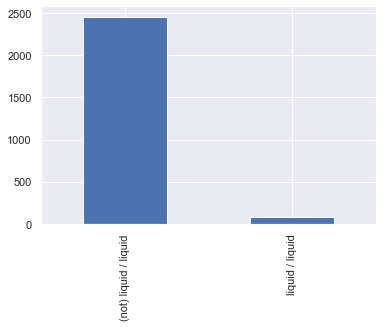

accuracy_score: 0.5967614533965245


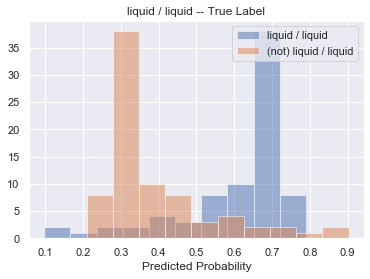

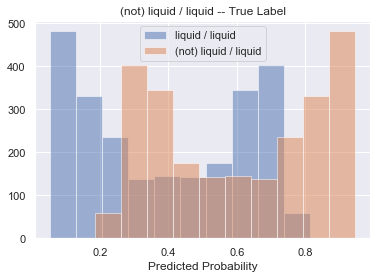

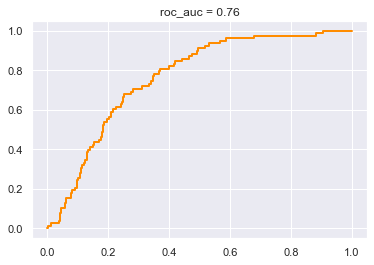

In [45]:
evaluate_gp_model('liquid / liquid', features_train, gp_liq_over_liq, df_test_liq_over_liq_processed)